In [4]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

data_path = 'D:\galaxy_classification\data3.csv'
image_dir = 'D:\galaxy_classification\images'

data = pd.read_csv(data_path)

class_mapping = {'S': 0, 'E': 1, 'SB': 2, 'EDGE': 3}

sampled_data = data.groupby('class').apply(lambda x: x.sample(15000, random_state=42)).reset_index(drop=True)

train_data, val_data = train_test_split(sampled_data, test_size=0.2, random_state=42)

def image_generator(data, batch_size, image_dir, class_mapping, augment=False):
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    ) if augment else ImageDataGenerator()

    num_samples = data.shape[0]
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = data.iloc[offset:offset+batch_size]
            
            images = []
            labels = []
            for _, row in batch_samples.iterrows():
                image_id = row['image_id']
                label = row['class']
                
                image_path = os.path.join(image_dir, f"{image_id}.jpg")
                
                if os.path.exists(image_path):
                    img = load_img(image_path, target_size=(128, 128))
                    img = img_to_array(img) / 255.0
                    images.append(img)
                    labels.append(class_mapping[label])
            
            X = np.array(images)
            y = to_categorical(np.array(labels), num_classes=len(class_mapping))
            
            if augment:
                yield next(datagen.flow(X, y, batch_size=batch_size))
            else:
                yield X, y
                
batch_size = 64

train_generator = image_generator(train_data, batch_size, image_dir, class_mapping, augment=True)
val_generator = image_generator(val_data, batch_size, image_dir, class_mapping, augment=False)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(len(class_mapping), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

X_test, y_test = next(train_generator)
print(f"Batch X shape: {X_test.shape}, Batch y shape: {y_test.shape}")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0

In [2]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=60,
    validation_data=val_generator,
    validation_steps=len(val_data) // batch_size,
    verbose=1
)

Epoch 1/60
750/750 [==============================] - 534s 705ms/step - loss: 1.0984 - accuracy: 0.5020 - val_loss: 1.0168 - val_accuracy: 0.5478
Epoch 2/60
750/750 [==============================] - 210s 281ms/step - loss: 0.9405 - accuracy: 0.5902 - val_loss: 0.8334 - val_accuracy: 0.6387
Epoch 3/60
750/750 [==============================] - 460s 614ms/step - loss: 0.8569 - accuracy: 0.6307 - val_loss: 0.7755 - val_accuracy: 0.6605
Epoch 4/60
750/750 [==============================] - 260s 348ms/step - loss: 0.8104 - accuracy: 0.6518 - val_loss: 0.7666 - val_accuracy: 0.6625
Epoch 5/60
750/750 [==============================] - 208s 278ms/step - loss: 0.7930 - accuracy: 0.6621 - val_loss: 0.7504 - val_accuracy: 0.6724
Epoch 6/60
750/750 [==============================] - 208s 278ms/step - loss: 0.7782 - accuracy: 0.6694 - val_loss: 0.7409 - val_accuracy: 0.6788
Epoch 7/60
750/750 [==============================] - 208s 277ms/step - loss: 0.7673 - accuracy: 0.6731 - val_loss: 0.7360 -

Epoch 57/60
750/750 [==============================] - 157s 210ms/step - loss: 0.6463 - accuracy: 0.7305 - val_loss: 0.6368 - val_accuracy: 0.7321
Epoch 58/60
750/750 [==============================] - 157s 210ms/step - loss: 0.6493 - accuracy: 0.7296 - val_loss: 0.6368 - val_accuracy: 0.7320
Epoch 59/60
750/750 [==============================] - 157s 210ms/step - loss: 0.6464 - accuracy: 0.7301 - val_loss: 0.6312 - val_accuracy: 0.7329
Epoch 60/60
750/750 [==============================] - 157s 210ms/step - loss: 0.6407 - accuracy: 0.7341 - val_loss: 0.6386 - val_accuracy: 0.7347


In [3]:
model.save('D:\galaxy_classification\galaxy_classifier.h5')

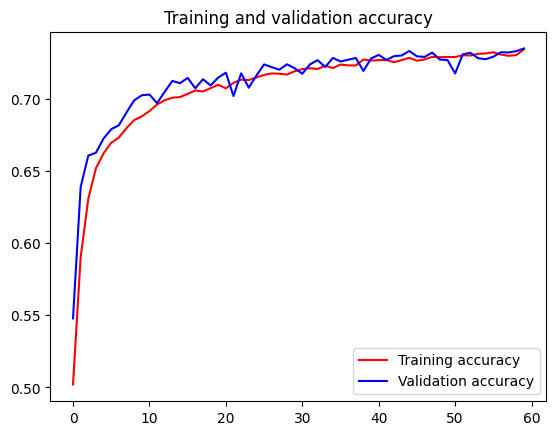

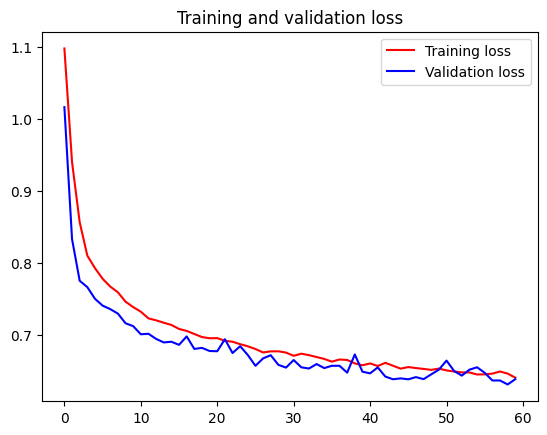

In [4]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

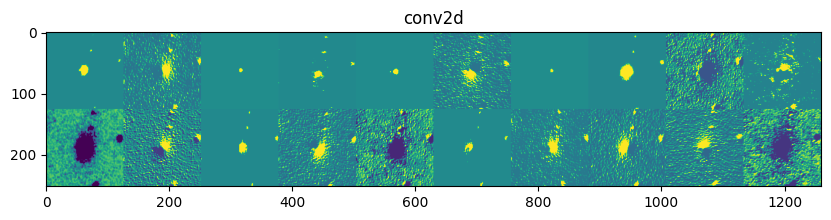

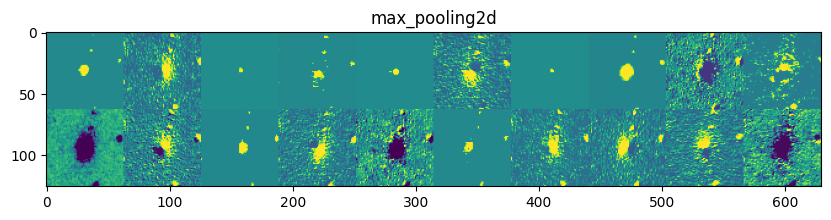

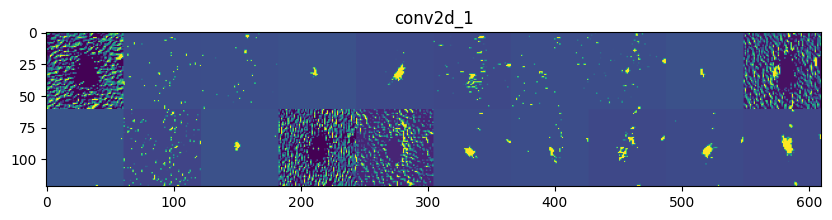

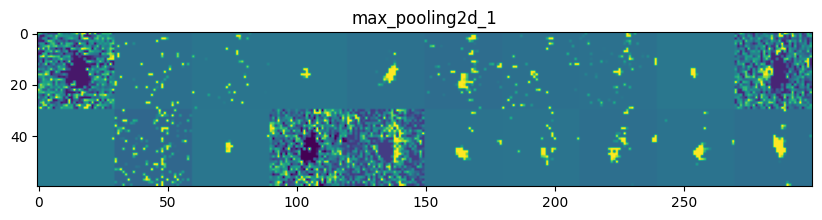

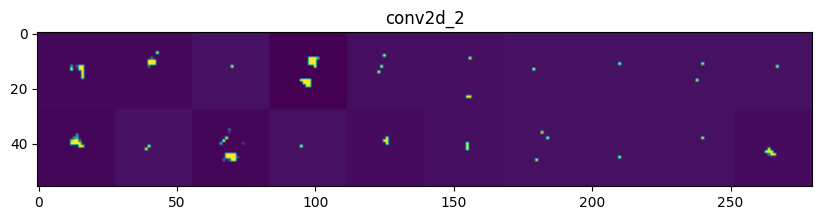

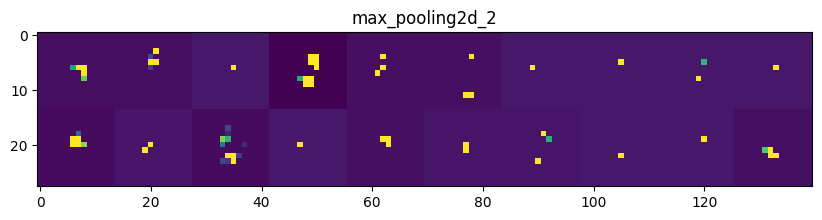

In [18]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

data_path = 'D:\\galaxy_classification\\data3.csv'
image_dir = 'D:\\galaxy_classification\\images'

data = pd.read_csv(data_path)

class_mapping = {'S': 0, 'E': 1, 'SB': 2, 'EDGE': 3}

model_path = 'D:\\galaxy_classification\\galaxy_classifier_ver20.h5'
model = load_model(model_path)

layer_outputs = [layer.output for layer in model.layers[:6]] 
activation_model = Model(inputs=model.input, outputs=layer_outputs)

image_id = data.iloc[0]['image_id'] 
img_path = os.path.join(image_dir, f"{image_id}.jpg")
img = load_img(img_path, target_size=(128, 128))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

activations = activation_model.predict(img_array)

layer_names = []
for layer in model.layers[:6]:
    layer_names.append(layer.name) 

images_per_row = 10
n_cols = 2

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1] 
    size = layer_activation.shape[1]
    active_channels = [i for i in range(n_features) if layer_activation[0, :, :, i].std() != 0]
    n_active = len(active_channels)
    if n_active == 0:
        continue 

    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for idx, i in enumerate(active_channels[:20]): 
        row = idx // images_per_row
        col = idx % images_per_row
        channel_image = layer_activation[0, :, :, i]
        channel_image -= channel_image.mean()
        channel_image /= (channel_image.std() + 1e-5)
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[row * size : (row + 1) * size, col * size : (col + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()



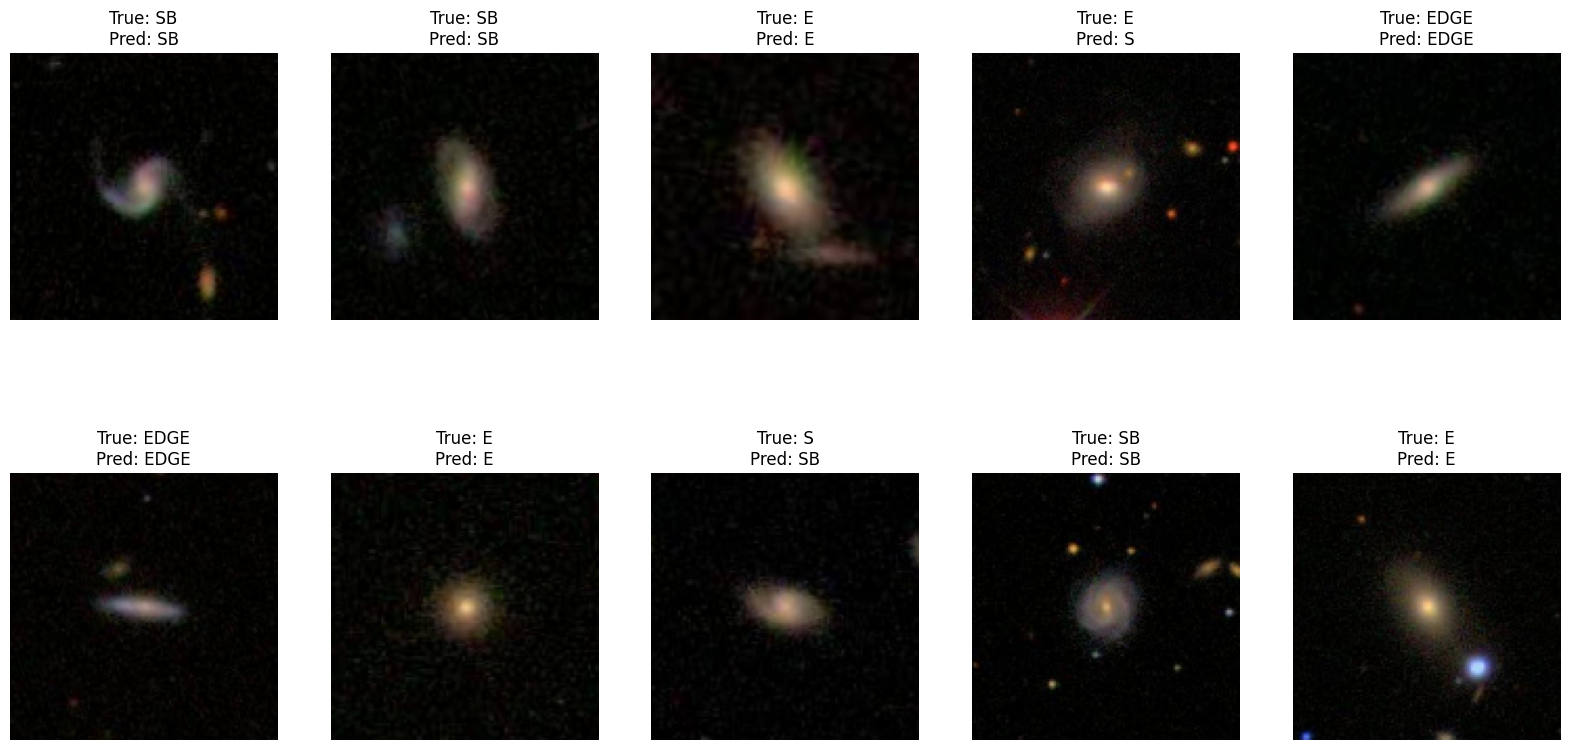

In [6]:
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np

data_path = 'D:\galaxy_classification\data3.csv'
image_dir = 'D:\galaxy_classification\images'

data = pd.read_csv(data_path)

class_mapping = {'S': 0, 'E': 1, 'SB': 2, 'EDGE': 3}

from sklearn.model_selection import train_test_split
_, val_data = train_test_split(data, test_size=0.2, random_state=42)

model_path = 'D:\galaxy_classification\galaxy_classifier_ver20.h5'

model = load_model(model_path)

def compare_predictions(model, data, image_dir, class_mapping, num_samples=10):
    samples = data.sample(n=num_samples)
    plt.figure(figsize=(20, 10))

    for i, (_, row) in enumerate(samples.iterrows()):
        image_id = row['image_id']
        true_label = row['class']
        
        image_path = os.path.join(image_dir, f"{image_id}.jpg")
        
        if os.path.exists(image_path):
            img = load_img(image_path, target_size=(128, 128))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=1)[0]
            
            inv_class_mapping = {v: k for k, v in class_mapping.items()}
            predicted_label = inv_class_mapping[predicted_class]
            
            plt.subplot(2, num_samples // 2, i + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label}\nPred: {predicted_label}")
            plt.axis('off')

    plt.show()

compare_predictions(model, val_data, image_dir, class_mapping, num_samples=10)

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17923669888017043787
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1838887732
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8264534093676302737
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


Loading validation data: 100%|██████████████████████████████████████████████████| 12000/12000 [00:20<00:00, 597.86it/s]


Accuracy: 0.6931


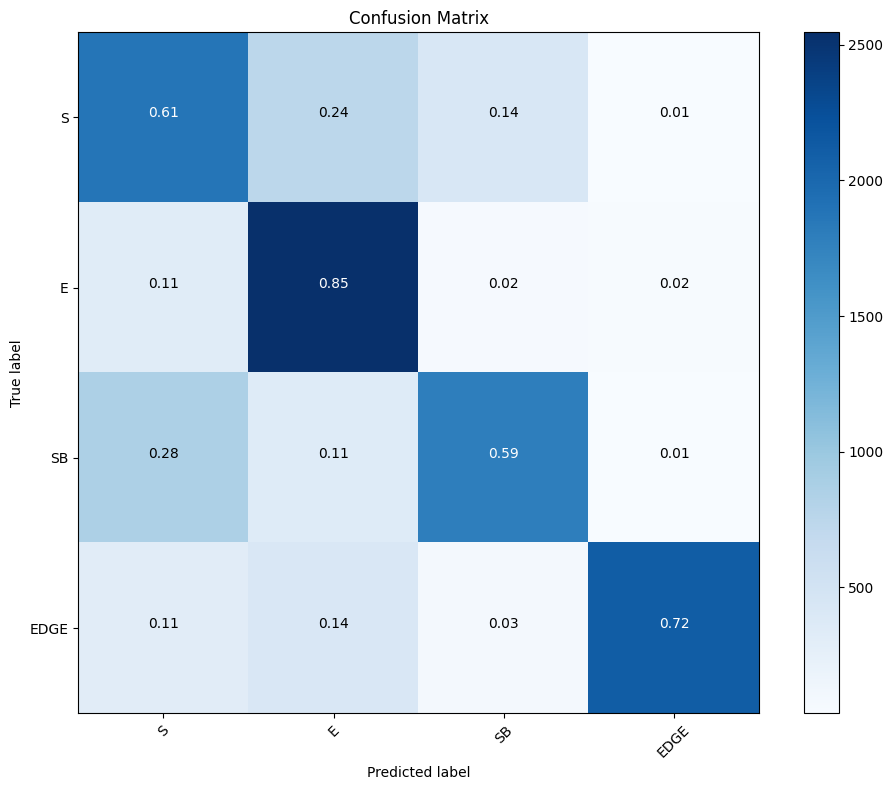

Classification Report:
               precision    recall  f1-score   support

           S       0.56      0.61      0.58      3077
           E       0.63      0.85      0.73      2984
          SB       0.75      0.59      0.66      3014
        EDGE       0.94      0.72      0.82      2925

    accuracy                           0.69     12000
   macro avg       0.72      0.69      0.70     12000
weighted avg       0.72      0.69      0.70     12000



Calculating ROC AUC: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 177.87it/s]


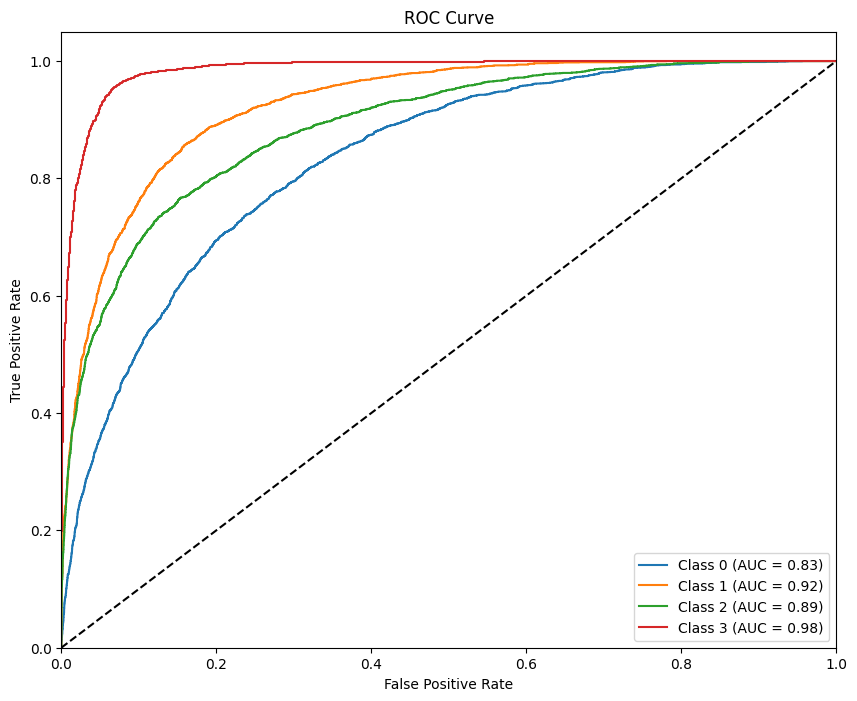

In [16]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import pandas as pd
import os
from sklearn.model_selection import train_test_split

model = load_model('D:/galaxy_classification/galaxy_classifier.h5')

data_path = 'D:/galaxy_classification/data3.csv'
image_dir = 'D:/galaxy_classification/images'
data = pd.read_csv(data_path)

class_mapping = {'S': 0, 'E': 1, 'SB': 2, 'EDGE': 3}

sampled_data = data.groupby('class').apply(lambda x: x.sample(15000, random_state=42)).reset_index(drop=True)

train_data, val_data = train_test_split(sampled_data, test_size=0.2, random_state=42)

def load_validation_data(val_data, image_dir, class_mapping):
    images = []
    labels = []
    for _, row in tqdm(val_data.iterrows(), total=val_data.shape[0], desc="Loading validation data"):
        image_id = row['image_id']
        label = row['class']
        
        image_path = os.path.join(image_dir, f"{image_id}.jpg")
        
        if os.path.exists(image_path):
            img = load_img(image_path, target_size=(128, 128))
            img = img_to_array(img) / 255.0
            images.append(img)
            labels.append(class_mapping[label])
    
    X_val = np.array(images)
    y_val = to_categorical(np.array(labels), num_classes=len(class_mapping))
    
    return X_val, y_val

X_val, y_val = load_validation_data(val_data, image_dir, class_mapping)
val_labels = np.argmax(y_val, axis=1)

val_predictions = model.predict(X_val)
pred_labels = np.argmax(val_predictions, axis=1)

pred_labels = np.where(pred_labels >= len(class_mapping), len(class_mapping) - 1, pred_labels)

accuracy = np.mean(pred_labels == val_labels)
print(f"Accuracy: {accuracy:.4f}")

conf_matrix = confusion_matrix(val_labels, pred_labels)

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_mapping))
plt.xticks(tick_marks, class_mapping.keys(), rotation=45)
plt.yticks(tick_marks, class_mapping.keys())

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], '.2f'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

class_report = classification_report(val_labels, pred_labels, target_names=list(class_mapping.keys()))
print("Classification Report:\n", class_report)

roc_auc = {}
plt.figure(figsize=(10, 8))
for i in tqdm(range(len(class_mapping)), desc="Calculating ROC AUC"):
    fpr, tpr, _ = roc_curve(y_val[:, i], val_predictions[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()